# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time

# Import API key
from api_keys import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

608

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [8]:
from time import sleep

url = "https://api.openweathermap.org/data/2.5/weather"
params = {"appid":api_key, # API Key
          "q":"", # query
          "units":"imperial" # Units in degrees fahrenheit
         }

In [5]:
weather_data = [] # List of JSON objects
err_message = "Skipping... could not find " # print(err_message + city_name)

print("Beginning Data Retrieval", "\n","-----------------------------")

counter = 0
num_cities = len(cities)

for city in cities:
    counter += 1
    params['q'] = city
    status = f'Retriving city data from {city}... '
    
    try:
        response = requests.get(url, params)
        
        # Response Handling: 200 is OK, 429 is BAD. Else, City skipped
        if response.status_code == 200:
            print(status+ f"Done! {counter} of {num_cities}")
        elif response.status_code == 429:
            print("Limit Reached. Account Blocked")
            break
        elif response.status_code == 404:
            print(err_message + city)
            continue
        
        # Max 60 calls per minute: prevent error 429
        if (counter % 60) == 0:
            print("Cycling...")
            sleep(60)
            print("Done!", "/n")

        weather_data.append(response)
    
    except requests.exceptions.RequestException as e:
        print(e)
        break_yn = input("Would you like to break? y/n")
        if break_yn == 'y':
            break
        else:
            continue

print("Done")

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [13]:
# Convert to JSON from weather_data
weather_jsons = [w.json() for w in weather_data]

In [35]:
# We need Temperature, Humidity, Cloudiness, and Wind Speed
weather_df = pd.DataFrame.from_dict(weather_jsons)


# JSON MESS

main_df = pd.DataFrame.from_dict(weather_df['main'].array) # temp, pressure, humidity, temp_max, temp_min
clouds_df = pd.DataFrame.from_dict(weather_df['clouds'].array) # all
wind_df = pd.DataFrame.from_dict(weather_df['wind'].array) # speed, deg
coord_df = pd.DataFrame.from_dict(weather_df['coord'].array) # lon, lat
sys_df = pd.DataFrame.from_dict(weather_df['sys'].array) # type, id, message, country, sunrise, sunset

# Recombine
weather_df = weather_df.drop(columns=['weather', 'base', 'main', 'clouds', 'wind', 'coord', 'sys', 'visibility',
                                      'timezone', 'id', 'cod']) # Actually unnecessary

weather_df = weather_df.merge(main_df, left_index=True, right_index=True)
weather_df = weather_df.merge(clouds_df, left_index=True, right_index=True)
weather_df = weather_df.merge(wind_df, left_index=True, right_index=True)
weather_df = weather_df.merge(coord_df, left_index=True, right_index=True)
weather_df = weather_df.merge(sys_df, left_index=True, right_index=True)

weather_df = weather_df.loc[:,['name', 'country', 'lat', 'lon','temp_max', 'humidity', 'all', 'speed', 'dt']]

columns = {'name': "City", 'country':'Country', 'lat':'Lat', 'lon':'Lng', 'temp_max':'Max Temp',
           'humidity':'Humidity', 'all':'Cloudiness', 'speed':'Wind Speed', 'dt':'Date'}
weather_df = weather_df.rename(columns = columns)

# Save to csv
weather_df.to_csv('./cities_weather.csv', index=False)

### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

In [38]:
imagepath = './Images/' # imagepath+title

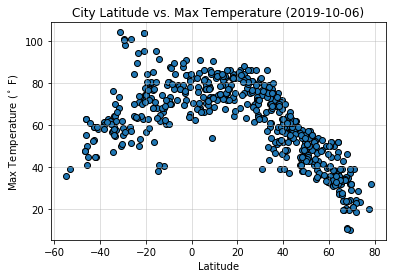

In [39]:
lats = weather_df['Lat'].to_numpy()
temps = weather_df['Max Temp'].to_numpy()
plt.scatter(lats, temps, edgecolor='k')
plt.grid(alpha=.5)
plt.xlabel('Latitude')
plt.ylabel('Max Temperature ($^\circ$ F)')
plt.title('City Latitude vs. Max Temperature (2019-10-06)')

plt.savefig(imagepath+'Latitude_Temp')
plt.show()

#### Latitude vs. Humidity Plot

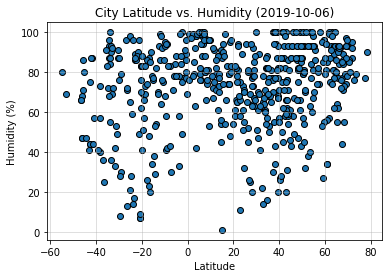

In [40]:
humids = weather_df['Humidity'].to_numpy()

plt.scatter(lats, humids, edgecolor='k')
plt.grid(alpha=.5)
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title('City Latitude vs. Humidity (2019-10-06)')

plt.savefig(imagepath+'Latitude_Humidity')
plt.show()

#### Latitude vs. Cloudiness Plot

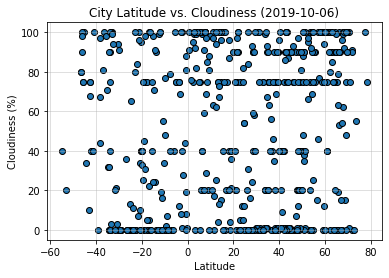

In [41]:
clouds = weather_df['Cloudiness'].to_numpy()

plt.scatter(lats, clouds, edgecolor='k')
plt.grid(alpha=.5)
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title('City Latitude vs. Cloudiness (2019-10-06)')

plt.savefig(imagepath+'Latitude_Cloudiness')
plt.show()

#### Latitude vs. Wind Speed Plot

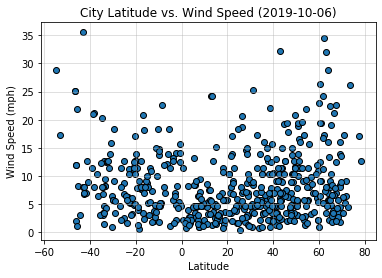

In [42]:
speedywindy = weather_df['Wind Speed'].to_numpy()

plt.scatter(lats, speedywindy, edgecolor='k')
plt.grid(alpha=.5)
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title('City Latitude vs. Wind Speed (2019-10-06)')

plt.savefig(imagepath+'Latitude_Wind')
plt.show()